In [35]:
import os
import gzip
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation_IMDB

In [36]:
def download_and_prepare_imdb_data(
    gz_filename="title.basics.tsv.gz",
    csv_filename="main_data.csv",
    url="https://datasets.imdbws.com/title.basics.tsv.gz"
):
    """
    Download and process IMDb movie data from the title.basics.tsv.gz file.
    If data already exists locally, it will be reused.

    Returns:
        pd.DataFrame: Processed IMDb movie data
    """
    # Step 1: Download gz file if not exists
    if not os.path.exists(gz_filename):
        print("IMDb file not found. Downloading...")
        response = requests.get(url)
        with open(gz_filename, "wb") as f:
            f.write(response.content)
        print("Download complete:", gz_filename)
    else:
        print("Using existing IMDb gz file:", gz_filename)

    # Step 2: Create CSV if not exists
    if not os.path.exists(csv_filename):
        print("Processing IMDb data...")
        with gzip.open(gz_filename, mode='rt', encoding='utf-8') as f:
            df_imdb = pd.read_csv(f, sep='\t', dtype=str)

        # Filter for movies only
        df_imdb = df_imdb[df_imdb['titleType'] == 'movie']

        # Keep only required columns
        df_imdb = df_imdb[['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres']].reset_index(drop=True)

        # Save to CSV
        df_imdb.to_csv(csv_filename, index=False)
        print("IMDb data saved as CSV:", csv_filename)
    else:
        print("Using existing IMDb CSV file:", csv_filename)
        df_imdb = pd.read_csv(csv_filename)

    # Final check
    print("Total movies loaded:", len(df_imdb))
    return df_imdb


# Data preparation_OMDB

In [37]:
def fetch_omdb_dataset(path='omdb_merged_data.csv'):
    """
    Load pre-fetched OMDB data from a local CSV file for reproducibility.

    Args:
        path (str): Path to the saved OMDB data CSV file.

    Returns:
        pd.DataFrame: Loaded OMDB dataset.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"OMDB dataset not found at: {path}")
    
    print(f"Loading OMDB data from {path}")
    return pd.read_csv(path, encoding="ISO-8859-1", low_memory=False)


# Merge functions

In [38]:
def merge_imdb_with_omdb(df_imdb, df_omdb):
    """
    Merge IMDb data with OMDB metadata using 'imdbID' as key.
    Automatically renames 'tconst' to 'imdbID' if needed.

    Args:
        df_imdb (pd.DataFrame): IMDb data (may contain 'tconst')
        df_omdb (pd.DataFrame): OMDB metadata (must contain 'imdbID')

    Returns:
        pd.DataFrame: Merged dataframe
    """
    if 'imdbID' not in df_imdb.columns and 'tconst' in df_imdb.columns:
        df_imdb = df_imdb.rename(columns={'tconst': 'imdbID'})

    return pd.merge(df_imdb, df_omdb, on='imdbID', how='left')


In [39]:
def merge_with_movielens(df_merged, ratings_file="ratings.csv", links_file="links.csv"):
    """
    Merge merged IMDb+OMDB data with MovieLens ratings.

    Args:
        df_merged (pd.DataFrame): IMDb + OMDB merged DataFrame (must include 'imdbID')
        ratings_file (str): Path to MovieLens ratings.csv
        links_file (str): Path to MovieLens links.csv

    Returns:
        pd.DataFrame: Final DataFrame with avg_rating and num_rating columns added
    """
    # Load MovieLens data
    ratings = pd.read_csv(ratings_file)
    links = pd.read_csv(links_file)

    # Compute average rating and rating count per movie
    movie_stats = ratings.groupby("movieId")["rating"].agg(
        avg_rating="mean",
        num_rating="count"
    ).reset_index()

    # Add imdbID (tt + zero-padding)
    movie_stats = pd.merge(movie_stats, links[["movieId", "imdbId"]], on="movieId", how="left")
    movie_stats["imdbID"] = "tt" + movie_stats["imdbId"].astype(str).str.zfill(7)

    # Merge with existing data
    df_final = pd.merge(df_merged, movie_stats[["imdbID", "avg_rating", "num_rating"]], on="imdbID", how="left")

    # Summary
    print("Final merged shape:", df_final.shape)    

    return df_final


# Cleaning & Save

In [40]:
def clean_final_dataframe(df):
    """
    Selects relevant columns and drops rows with missing critical values.

    Args:
        df (pd.DataFrame): Final merged DataFrame

    Returns:
        pd.DataFrame: Cleaned DataFrame with required fields only
    """
    selected_columns = [
        'imdbID', 'primaryTitle', 'startYear', 'director', 'writer',
        'actors', 'language', 'country', 'runtimeMinutes',
        'genres', 'plot', 'num_rating', 'avg_rating'
    ]

    required_fields = [
        'director', 'writer', 'actors', 'plot',
        'language', 'country', 'num_rating', 'avg_rating'
    ]

    df = df[selected_columns]
    df = df.dropna(subset=required_fields)

    print("Cleaned DataFrame shape:", df.shape)
    return df


In [41]:
def save_dataframe(df, filename="df_final.csv"):
    """
    Save DataFrame to CSV if file does not already exist.
    """
    if os.path.exists(filename):
        print(f"Warning: '{filename}' already exists. Skipping save to avoid overwrite.")
    else:
        df.to_csv(filename, index=False)
        print(f"DataFrame saved to '{filename}'")

# Plot

In [42]:
def plot_rating_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.histplot(df['avg_rating'], bins=20, kde=True, color='skyblue')
    plt.title("Distribution of Average Ratings")
    plt.xlabel("Average Rating")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [43]:
def plot_runtime_distribution(df):
    df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')
    plt.figure(figsize=(8, 5))
    sns.histplot(df['runtimeMinutes'].dropna(), bins=30, kde=True, color='salmon')
    plt.title("Distribution of Movie Runtimes")
    plt.xlabel("Runtime (minutes)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [44]:
def plot_top_genres(df, top_n=10):
    genres = df['genres'].dropna().str.split(',')
    flat_genres = [g.strip() for sublist in genres for g in sublist]
    top = pd.Series(flat_genres).value_counts().nlargest(top_n)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=top.values, y=top.index, palette='viridis')
    plt.title(f"Top {top_n} Genres")
    plt.xlabel("Number of Movies")
    plt.ylabel("Genre")
    plt.tight_layout()
    plt.show()


In [45]:
def plot_movies_by_year(df):
    df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce')
    df_year = df['startYear'].dropna()
    plt.figure(figsize=(10, 5))
    sns.histplot(df_year, bins=30, kde=False, color='skyblue')
    plt.title("Number of Movies by Release Year")
    plt.xlabel("Release Year")
    plt.ylabel("Movie Count")
    plt.tight_layout()
    plt.show()


In [46]:
def plot_genre_rating_subplots(df, min_count=0):
    df_genres = df.dropna(subset=['genres', 'avg_rating']).copy()
    df_genres['genre_list'] = df_genres['genres'].str.split(',')
    df_exploded = df_genres.explode('genre_list')
    df_exploded['genre_list'] = df_exploded['genre_list'].str.strip()

    pivot_table = df_exploded.pivot_table(
        index='genre_list',
        values='avg_rating',
        aggfunc=['count', 'mean']
    ).round(2)

    pivot_table.columns = ['Movie Count', 'Average Rating']
    
    if min_count > 0:
        pivot_table = pivot_table[pivot_table['Movie Count'] >= min_count]

    pivot_table = pivot_table.sort_values('Movie Count', ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(16, len(pivot_table) * 0.4), sharey=True)

    sns.heatmap(
        pivot_table[['Movie Count']],
        annot=True, fmt=".0f", cmap="Blues",
        ax=axes[0], cbar_kws={'label': 'Movie Count'}
    )
    axes[0].set_title("Genre-wise Movie Count")

    sns.heatmap(
        pivot_table[['Average Rating']],
        annot=True, fmt=".2f", cmap="YlOrBr",
        ax=axes[1], cbar_kws={'label': 'Average Rating'}
    )
    axes[1].set_title("Genre-wise Average Rating")

    plt.tight_layout()
    plt.show()


# Main execution

### Data Reproducibility Notice

To ensure reproducibility and consistent results in both unsupervised and supervised learning models, this project uses a frozen version of the final dataset: `df_final_frozen_62188.csv`.

Although the same codebase can generate a different number of records (e.g., 62,348 rows) due to updates in upstream sources (OMDB/MovieLens), we fix the dataset snapshot to 62,188 movies. This version has been validated and used throughout our modeling pipeline.

We strongly advise against regenerating the dataset from scratch, as it may cause inconsistencies in modeling results.


Using frozen version of df_final_frozen_62188.csv for reproducibility.


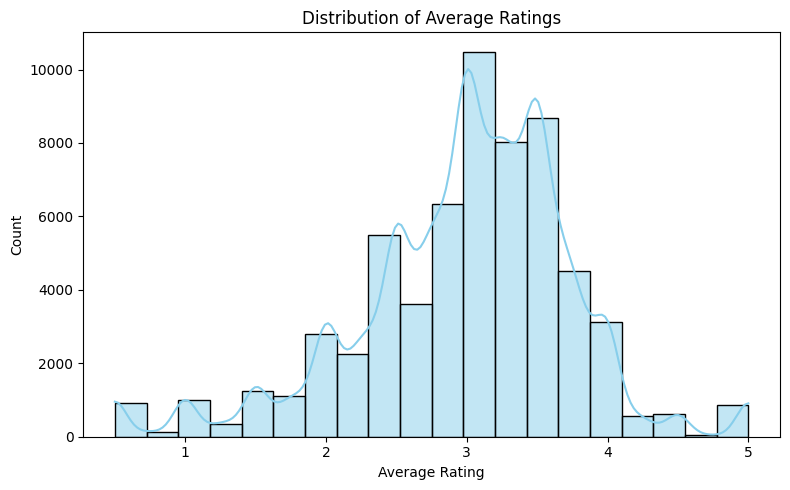

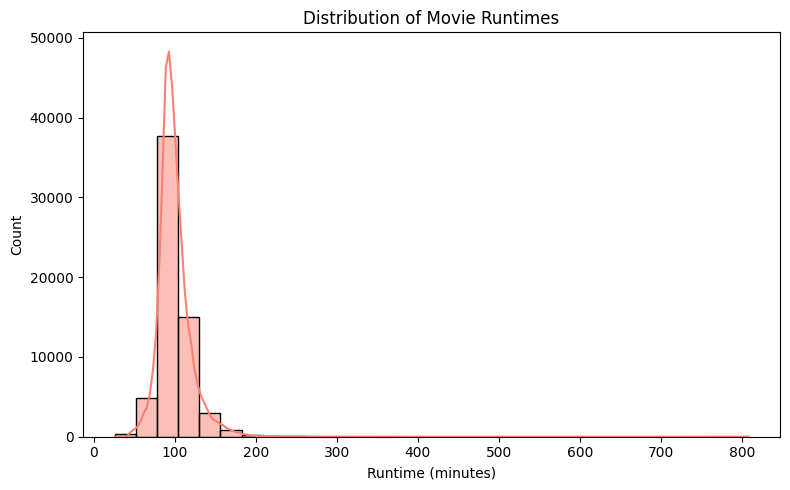

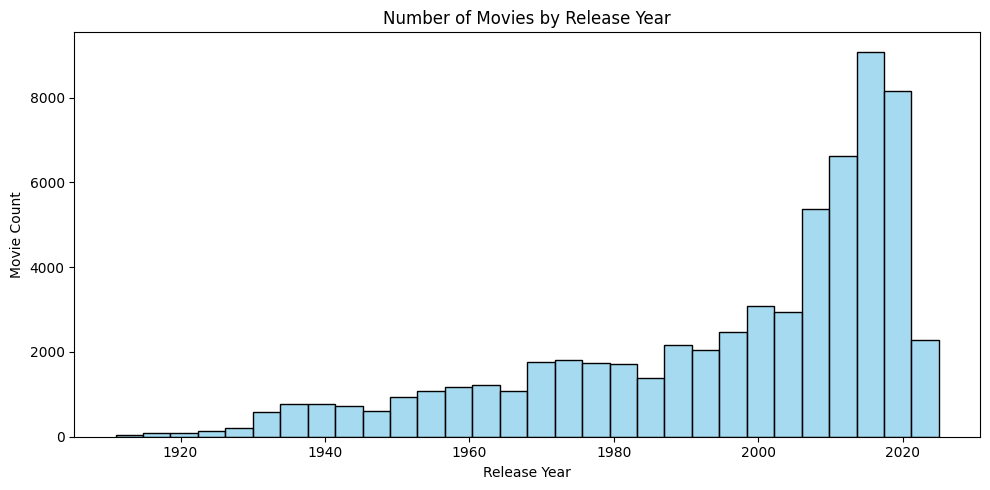

C:\Users\SKTelecom\AppData\Local\Temp\ipykernel_3580\4010765919.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette='viridis')


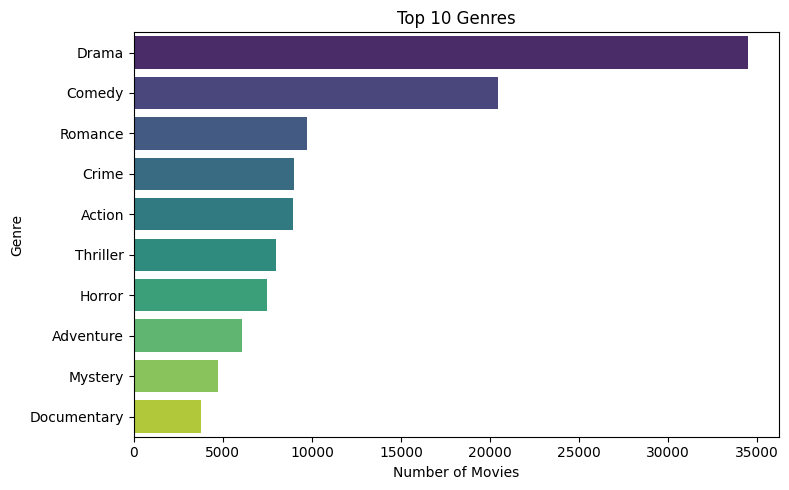

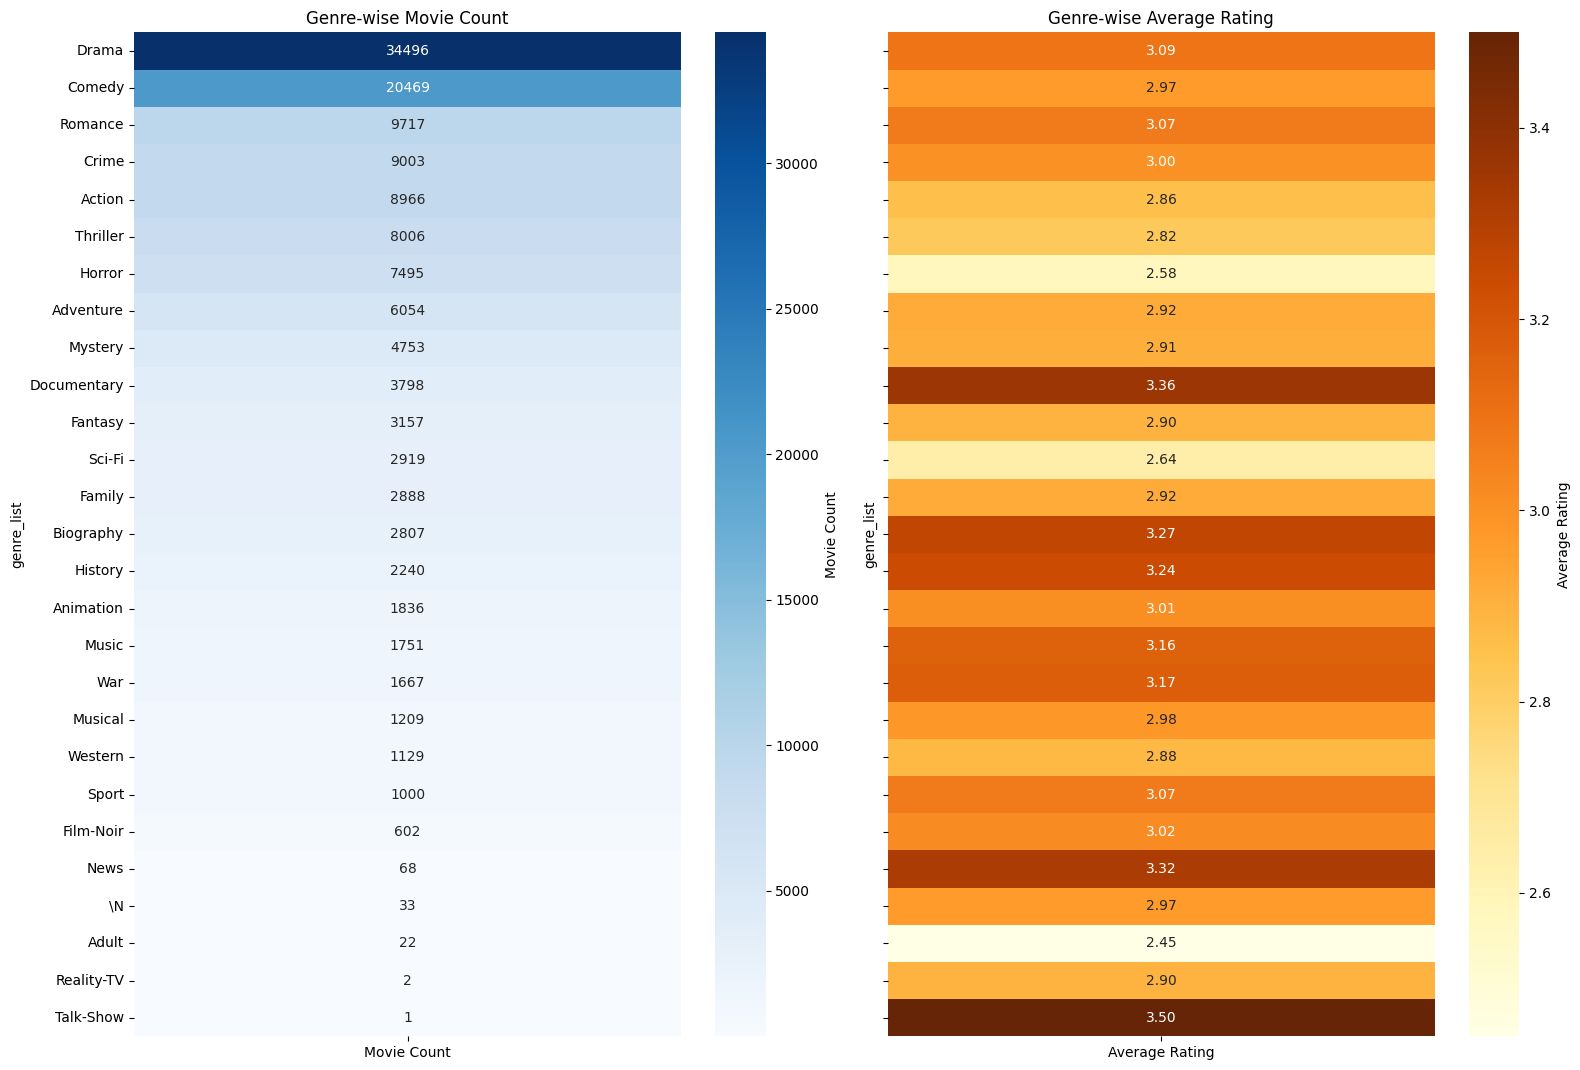

In [49]:
def main():
    FROZEN_DF_PATH = "df_final_frozen_62188.csv"

    if os.path.exists(FROZEN_DF_PATH):
        print("Using frozen version of df_final_frozen_62188.csv for reproducibility.")
        df_final = pd.read_csv(FROZEN_DF_PATH)
    else:
        raise FileNotFoundError(
            f"{FROZEN_DF_PATH} not found.\n"
            f"This project is based on a fixed version of df_final.csv (62188 rows).\n"
            f"To ensure full reproducibility, please use the frozen file."
        )

    # Run visualizations
    plot_rating_distribution(df_final)
    plot_runtime_distribution(df_final)
    plot_movies_by_year(df_final)
    plot_top_genres(df_final)
    plot_genre_rating_subplots(df_final)


if __name__ == "__main__":
    main()



In [ ]:
### The code below is the code used for the initial data preparation. 
### For data reproducibility, the main function is used to use df_final_frozen_62188.csv from the second time onwards.


# def main():
#     final_filename = "df_final.csv"

#     if os.path.exists(final_filename):
#         print(f"'{final_filename}' already exists. Skipping data generation.")
#         df_final = pd.read_csv(final_filename)
#     else:
#          # Step 1: Download and preprocess IMDb data
#         df_imdb = download_and_prepare_imdb_data()
    
#         # Step 2: Load OMDB data 
#         df_omdb = fetch_omdb_dataset()
    
#         # Step 3: Merge IMDb and OMDB data
#         df_merged = merge_imdb_with_omdb(df_imdb, df_omdb)
    
#         # Step 4: Merge with MovieLens ratings
#         df_final = merge_with_movielens(df_merged)
    
#         # Step 5: Clean final dataframe (select columns and drop missing)
#         df_final = clean_final_dataframe(df_final)
    
#         # Step 6: Save the final dataframe safely
#         save_dataframe(df_final, filename=final_filename)

# if __name__ == "__main__":
#     main()
